這份程式是為了輔助說明李宏毅教授《生成式人工智慧及機器學習導論》第三講的觀念，目的是透過執行此程式，讓學生更清楚理解大型語言模型內部的類神經網路如何運作。在開始執行之前，請先點選上方工具列的「檔案」，選擇「在雲端硬碟中儲存副本」，再於自己的副本中進行操作。

In [ ]:
!pip install -U transformers     #安裝 HuggingFace Transformers 套件
import torch

In [2]:
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

以下程式碼將登入 Hugging Face Hub，以便接下來取得模型。但在此之前，我們需先取得 Hugging Face 的「Token」（此處的 Token 指的是認證憑證，與生成式 AI 中的 token 無關）。有關 Hugging Face Token 的取得與使用方式，請參閱作業一助教投影片：https://speech.ee.ntu.edu.tw/~hylee/GenAI-ML/2025-fall-course-data/hw1.pdf

In [3]:
from huggingface_hub import login
from google.colab import userdata

# Saving your token as a secret key in Colab is recommended for safety
hf_token = userdata.get('HF_TOKEN')
# While it's strongly unrecommended, you can also type in your token for convenience
#hf_token = "<replace_with_your_token>"

login(token=hf_token)

我們將下載位於此頁面的模型：https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct

如果你之前沒有使用過這個模型，在上述頁面中你可能會看到一行提示：「You need to agree to share your contact information to access this model」。這是因為使用 Llama 模型需要先簽署使用者同意書（並不是每個模型都需要簽署同意書）。請依照該頁面上的指示完成簽署，之後你會收到一封通知信，告知審查是否通過，通過後才能開始使用。這個過程有時可能需要數個小時。詳情請參閱助教投影片。

執行以下程式碼後，我們會從 Hugging Face Hub 下載 tokenizer 和 model 兩個物件。tokenizer 紀錄了模型所使用的 token，而 model 則儲存了模型的參數。下載過程可能需要數分鐘，請耐心等候。

In [4]:
model_id = "google/gemma-3-4b-it"
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    #torch_dtype=torch.bfloat16
)
# Load Processor: Handles both text tokenization and image formatting
processor = AutoProcessor.from_pretrained(model_id)

print("Model loaded successfully!")

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Model loaded successfully!


In [5]:
model.device

device(type='cpu')

In [6]:
# ==========================================
# 2. DEFINE YOUR PATENT DATA (TIPO CONTEXT)
# ==========================================
# Example: G11C Memory Technology
#claim_text = "一種非揮發性記憶體單元，包含一電荷捕捉層(charge trapping layer)位於穿隧氧化層與阻擋氧化層之間。"
#prior_art_text = "段落 [0045]: 該記憶體裝置利用一浮動閘極(floating gate)作為電荷儲存元件，該浮動閘極由多晶矽組成。"

# ==========================================
# 3. CONSTRUCT THE PROMPT
# ==========================================
# We use the chat structure. Note: We are asking for Traditional Chinese output.
chat_messages = [
    {
        "role": "user",
        "content": """
你是一位台灣專利局 (TIPO) 的審查官。請教我如何比對「請求項」與「前案段落」。

"""
    }
]



In [7]:
# We use the chat structure. Note: We are asking for Traditional Chinese output.
chat_messages = [
    {
        "role": "user",
        "content": """
你是一位台灣人。台灣總統是誰?

"""
    }
]


In [8]:
# Step A: Create the raw prompt string first
# We use the tokenizer inside the processor to handle the chat template
prompt = processor.tokenizer.apply_chat_template(
    chat_messages,
    tokenize=False,  # <--- Vital: Return the string, don't convert to numbers yet
    add_generation_prompt=True
)

In [9]:
prompt

'<bos><start_of_turn>user\n你是一位台灣人。台灣總統是誰?<end_of_turn>\n<start_of_turn>model\n'

In [10]:
inputs = processor(
    text=prompt,
    images=None,         # Explicitly say no images
    return_tensors="pt"
).to(model.device)

In [11]:
inputs

{'input_ids': tensor([[     2,      2,    105,   2364,    107, 237408, 213062,  44953, 237086,
         236924,  44953, 180437, 237026, 240560, 236881,    106,    107,    105,
           4368,    107]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [12]:
# Generate Response
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        do_sample=False,
        temperature=0.0
    )

# Decode
input_len = inputs.input_ids.shape[1]
print(input_len)
print(outputs)
generated_text = processor.batch_decode(outputs[:, input_len:], skip_special_tokens=True)[0]

print("-" * 30)
print("GEMMA 3 ANALYSIS RESULT:")
print("-" * 30)
print(generated_text)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


20
tensor([[     2,      2,    105,   2364,    107, 237408, 213062,  44953, 237086,
         236924,  44953, 180437, 237026, 240560, 236881,    106,    107,    105,
           4368,    107,  23965,  44953, 236918, 180437, 237026, 243219, 238128,
         238624, 236924,    107,    106]])
------------------------------
GEMMA 3 ANALYSIS RESULT:
------------------------------
現在台灣的總統是賴清德。



In [14]:
processor.decode([ 2,      2,    105,   2364,    107, 237408, 213062,  44953, 237086,
         236924,  44953, 180437, 237026, 240560, 236881,    106,    107,    105,
           4368,    107])

'<bos><bos><start_of_turn>user\n你是一位台灣人。台灣總統是誰?<end_of_turn>\n<start_of_turn>model\n'

In [13]:
processor.decode([23965,  44953, 236918, 180437, 237026, 243219, 238128,
         238624, 236924,    107,    106])

'現在台灣的總統是賴清德。\n<end_of_turn>'

深度學習模型的參數通常以多個矩陣（Matrix）和向量（Vector）的形式儲存（向量、矩陣等統稱為張量（Tensor））。  

在模型中，每個包含參數的張量在 `model` 中具有以下資訊：  

- **名稱（name）**：表示該參數在模型結構中的位置，例如 `model.layers.0.mlp.up_proj.weight`，這是第一個 transformer layer 中第一層 MLP 的參數。  
- **形狀（shape）**：表示該張量的維度，例如 `(8192, 3072)`，代表這是一個矩陣，其中一維為 8192，另一維為 3072。  

我們可以用 `named_parameters()` 方法來逐一查看這些參數。


*italicized text*## 輸出每一層的 representation

把每一層的 representation 都取出來

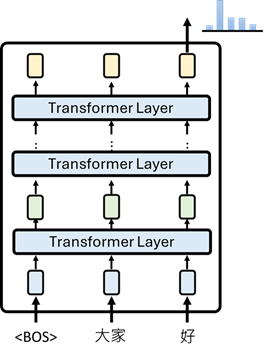

In [ ]:
processor.tokenizer.decode([   2, 58725])

'<bos>大家好'

In [ ]:
inputs = processor.tokenizer.encode("大家好", return_tensors="pt")

print("編碼後的 Token IDs：", inputs)

outputs = model(inputs, output_hidden_states=True) # output_hidden_states=True 才會回傳每一層的 representation (hidden states)

hidden_states = outputs.hidden_states
# hidden_states[0] -> embedding （把 token 轉成 token embedding 的結果)
# hidden_states[1] ~ hidden_states[N] -> 每一層 Transformer block 的輸出
print(f"一共拿到 {len(hidden_states)} 層 representation（包含 token embedding）。")

# 列出每層輸出的形狀
for idx, h in enumerate(hidden_states):
    print(f"Layer {idx:2d} 輸出形狀: {h.shape}")
    # h.shape = [batch_size, seq_len, hidden_size]
    # batch_size → 一次處理的句子數
    # sequence_length → 句子被切成多少 token
    # hidden_size → 每個 token 的向量長度


print("\n=== Token Embedding 輸出 ===")
print(hidden_states[0])

print("\n=== 第一個 Transformer Layer 的輸出 ===")
print(hidden_states[1])

編碼後的 Token IDs： tensor([[    2, 58725]])
一共拿到 35 層 representation（包含 token embedding）。
Layer  0 輸出形狀: torch.Size([1, 2, 2560])
Layer  1 輸出形狀: torch.Size([1, 2, 2560])
Layer  2 輸出形狀: torch.Size([1, 2, 2560])
Layer  3 輸出形狀: torch.Size([1, 2, 2560])
Layer  4 輸出形狀: torch.Size([1, 2, 2560])
Layer  5 輸出形狀: torch.Size([1, 2, 2560])
Layer  6 輸出形狀: torch.Size([1, 2, 2560])
Layer  7 輸出形狀: torch.Size([1, 2, 2560])
Layer  8 輸出形狀: torch.Size([1, 2, 2560])
Layer  9 輸出形狀: torch.Size([1, 2, 2560])
Layer 10 輸出形狀: torch.Size([1, 2, 2560])
Layer 11 輸出形狀: torch.Size([1, 2, 2560])
Layer 12 輸出形狀: torch.Size([1, 2, 2560])
Layer 13 輸出形狀: torch.Size([1, 2, 2560])
Layer 14 輸出形狀: torch.Size([1, 2, 2560])
Layer 15 輸出形狀: torch.Size([1, 2, 2560])
Layer 16 輸出形狀: torch.Size([1, 2, 2560])
Layer 17 輸出形狀: torch.Size([1, 2, 2560])
Layer 18 輸出形狀: torch.Size([1, 2, 2560])
Layer 19 輸出形狀: torch.Size([1, 2, 2560])
Layer 20 輸出形狀: torch.Size([1, 2, 2560])
Layer 21 輸出形狀: torch.Size([1, 2, 2560])
Layer 22 輸出形狀: torch.Size([1, 2, 